**Model training in three ways:**

- using images obtained with `MFCC` in `07_preprocessing_mfcc.ipynb`
- using spectrograms transformed by `MFCC` on the fly
- using spectrograms transformed by `MFCC` on the fly with augmentations

In [1]:
import os
import yaml
import joblib
#
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
#
import torchvision
from torchvision.io import read_image
from torchvision.transforms import ConvertImageDtype
#
from sklearn.model_selection import train_test_split
#
from utils.modelling import training, testing
from utils.spectrograms import get_spectrogram
from utils.augmentations import augment, masking
from utils.miscellaneous import update_stats
from utils.plot import get_figure, update_figure
#
from IPython.display import Image

In [2]:
print(torch.__version__)
print(torchaudio.__version__)
print(torchvision.__version__)

2.3.0+cu121
2.3.0+cu121
0.18.0+cu121


In [3]:
raw_path = 'data/raw/'
data_path = 'data/mfcc/'

In [4]:
LEARNING_RATE = 0.0001

In [5]:
labels = yaml.safe_load(open('labels.yaml'))[2022]

In [6]:
X, y = zip(*labels.items())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)

# Modelling using images

In [7]:
device = 'cpu'

In [8]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y
        self.cid = ConvertImageDtype(torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        image = read_image(f'{data_path}/{episode}.png')
        return self.cid(image), int(label)

In [9]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [10]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [18]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(4, 8)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(4, 8))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(3, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(8, 32)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(8, 32))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(1024, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, x):
        shapes = [x.shape]
        # print()
        x = self.layer1(x)
        shapes.append(x.shape)
        # x = self.layer2(x)
        shapes.append(x.shape)
        x = self.layer3(x)
        # shapes.append(x.shape)
        #
        # print(shapes)
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        # print(x.shape, self.training)
        #
        print('=' if self.training else '-', end='')
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
filename = '08_mfcc_images'

In [21]:
# !rm artifacts/08_mfcc_images.joblib
# !rm artifacts/08_mfcc_images.pt

In [22]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats is loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

In [23]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': '71c5f724-4c70-4478-ae57-cf3a01e88b17',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'red', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Testing',
              'type': 'scatter',
              'uid': '79b5e477-796d-4e02-9195-49c4a7f3430f',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', '

In [24]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader, device)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader, device)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

==============================================================================--------------------------
Epoch: 0 | Training loss: 0.6410 | Testing loss: 0.5981 | Training AUC: 0.4545 | Testing AUC: 0.7068
==============================================================================--------------------------
Epoch: 1 | Training loss: 0.6175 | Testing loss: 0.5957 | Training AUC: 0.4448 | Testing AUC: 0.7143
==============================================================================--------------------------
Epoch: 2 | Training loss: 0.6042 | Testing loss: 0.5791 | Training AUC: 0.4854 | Testing AUC: 0.7218
==============================================================================--------------------------
Epoch: 3 | Training loss: 0.6066 | Testing loss: 0.5811 | Training AUC: 0.4554 | Testing AUC: 0.7293
==============================================================================--------------------------
Epoch: 4 | Training loss: 0.6162 | Testing loss: 0.5939 | Training AUC:

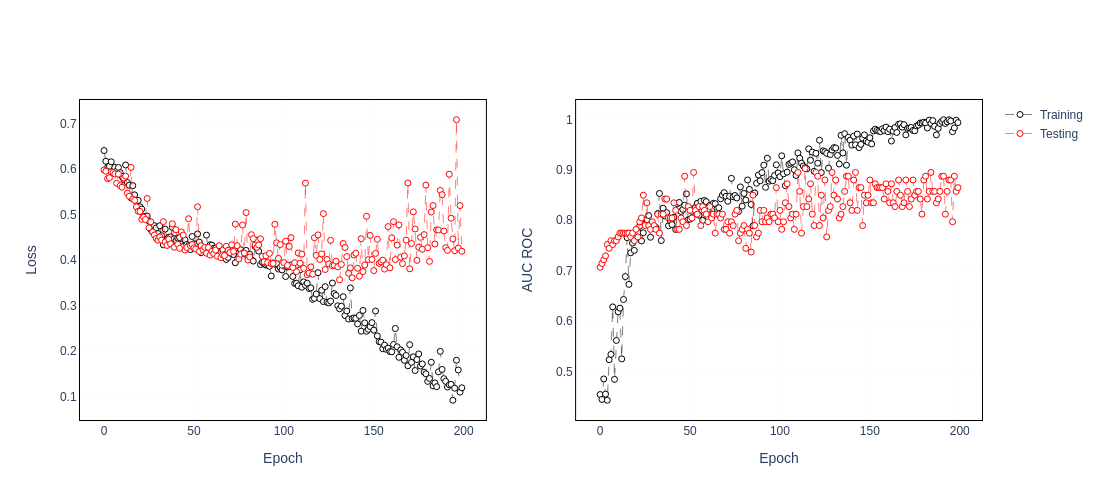

In [7]:
Image('artifacts/08_mfcc_images.png')

# Modelling `as is`

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        #
        waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
        #
        return get_spectrogram(waveform.mean(dim=0), sample_rate, 'mfcc'), label

In [9]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [10]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [11]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 8)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(4, 8))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(3, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 16)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(8, 32))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(256, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        # print('.', end='')
        shapes = [x.shape]
        # print()
        x = self.layer1(x)
        shapes.append(x.shape)
        # x = self.layer2(x)
        shapes.append(x.shape)
        x = self.layer3(x)
        # print(shapes, self.training)
        #
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        print('=' if self.training else '-', end='')
        #
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
filename = '08_mfcc'

In [15]:
# !rm artifacts/08_mfcc.joblib
# !rm artifacts/08_mfcc.pt

In [14]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats are loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

!Model weights are loaded.
!Training stats are loaded.


In [15]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': 'fdfae0df-df26-49cb-88f4-788f3b88b371',
              'x': [0, 1, 2, ..., 195, 196, 197],
              'xaxis': 'x',
              'y': [0.930540144443512, 0.5786054730415344, 0.6408951878547668,
                    ..., 0.105527363717556, 0.13147777318954468,
                    0.08869211375713348],
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'red', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Testing',
              'type': 'scatter',
              'uid': '2b91464c-4952-417b-9912-d712657229c3',
              'x': [0, 1, 2, 

In [16]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader, device)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader, device)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

=

/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



=============================================================================--------------------------
Epoch: 197 | Training loss: 0.0947 | Testing loss: 0.3695 | Training AUC: 0.9968 | Testing AUC: 0.9474
==============================================================================--------------------------
Epoch: 198 | Training loss: 0.1457 | Testing loss: 0.4109 | Training AUC: 0.9813 | Testing AUC: 0.9474
==============================================================================--------------------------
Epoch: 199 | Training loss: 0.1066 | Testing loss: 0.3134 | Training AUC: 0.9943 | Testing AUC: 0.9474


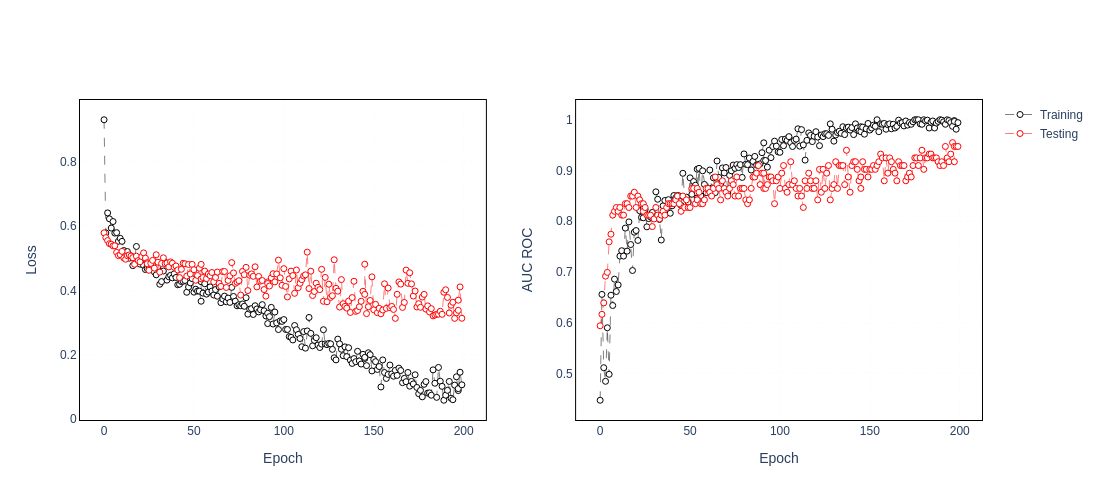

In [17]:
Image('artifacts/08_mfcc.png')

## + augmentations

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
from utils.augmentations import augment, masking
from utils.spectrograms import get_spectrogram
from utils.miscellaneous import update_stats
from utils.plot import get_figure, update_figure

In [9]:
class Podcast(Dataset):

    def __init__(self, X, y, clipping=True, training=True):
        self.x = X
        self.y = y
        self.clipping = clipping
        self.training = training

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        #
        waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
        waveform = waveform.mean(dim=0)
        #
        if self.training:
            waveform = augment(waveform, sample_rate, self.clipping)
        spectrogram = get_spectrogram(waveform, sample_rate, 'mfcc')
        if self.training:
            spectrogram = masking(spectrogram)
        #
        return spectrogram, label

In [10]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [11]:
test = Podcast(X_test, y_test, training=False)
test_dataloader = DataLoader(test)

In [12]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 8)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(4, 8))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(3, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 16)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(8, 32))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(256, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        # print('.', end='')
        shapes = [x.shape]
        # print()
        x = self.layer1(x)
        shapes.append(x.shape)
        # x = self.layer2(x)
        shapes.append(x.shape)
        x = self.layer3(x)
        # print(shapes, self.training)
        #
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        print('=' if self.training else '-', end='')
        #
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
filename = '08_mfcc_augmented'

In [16]:
# !rm artifacts/08_mfcc_augmented.joblib
# !rm artifacts/08_mfcc_augmented.pt

In [15]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats is loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

!Model weights are loaded.
!Training stats is loaded.


In [16]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': '0d066fb1-d42b-4cb7-887e-cb71d932856c',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
                    49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
                    65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 76, 77, 78, 79,
                    80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
                    96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
                    109, 110, 111, 112, 113, 114, 115, 116, 117, 117

In [ ]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader, device)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader, device)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

=

/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



=============================================================================--------------------------
Epoch: 160 | Training loss: 0.4589 | Testing loss: 0.4472 | Training AUC: 0.8093 | Testing AUC: 0.7970
!Model weights were saved.
==============================================================================--------------------------
Epoch: 161 | Training loss: 0.4586 | Testing loss: 0.4667 | Training AUC: 0.7922 | Testing AUC: 0.8045
==============================================================================--------------------------
Epoch: 162 | Training loss: 0.5138 | Testing loss: 0.4656 | Training AUC: 0.7614 | Testing AUC: 0.8045
==============================================================================--------------------------
Epoch: 163 | Training loss: 0.5408 | Testing loss: 0.4689 | Training AUC: 0.7394 | Testing AUC: 0.8045
==============================================================================--------------------------
Epoch: 164 | Training loss: 0.4700 | 

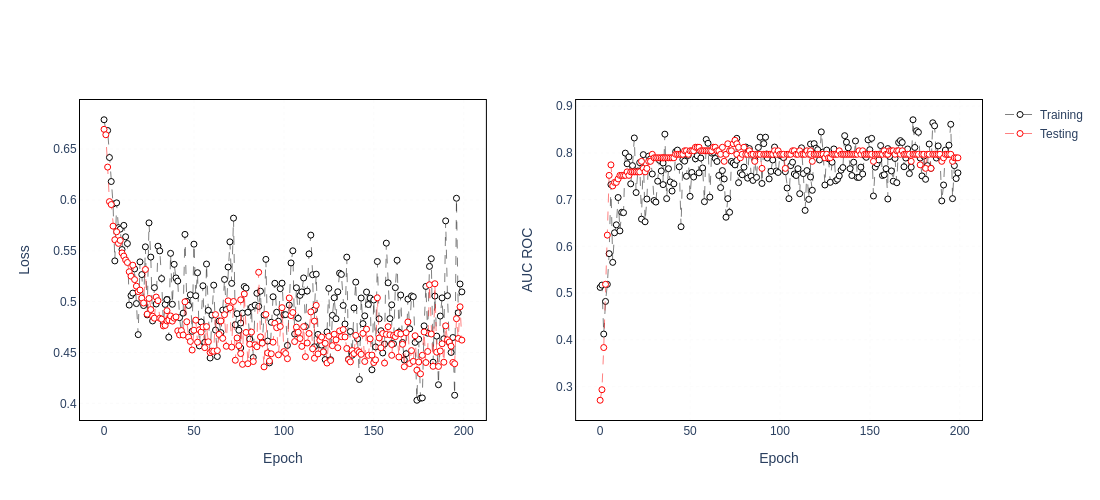

In [7]:
Image('artifacts/08_mfcc_augmented.png')